<a href="https://colab.research.google.com/github/clar04/Emotion-Classification/blob/main/Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier



In [5]:
train_df = pd.read_csv('data_train.csv')
test_df = pd.read_csv('data_test.csv')

## EDA Data Train

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       4320 non-null   int64 
 1   Category         4320 non-null   object
 2   Product Name     4320 non-null   object
 3   Location         4320 non-null   object
 4   Price            4320 non-null   int64 
 5   Overall Rating   4320 non-null   int64 
 6   Number Sold      4320 non-null   int64 
 7   Total Review     4320 non-null   int64 
 8   Customer Rating  4320 non-null   int64 
 9   Customer Review  4320 non-null   object
 10  Emotion          4320 non-null   object
dtypes: int64(6), object(5)
memory usage: 371.4+ KB


In [7]:
train_df.describe()

,Unnamed: 0,Price,Overall Rating,Number Sold,Total Review,Customer Rating
count,4320.000000,4.320000e+03,4320.000000,4320.000000,4320.000000,4320.000000
mean,2703.700463,2.365402e+05,48.541667,15643.848380,2129.128472,3.095139
std,1553.629759,7.826490e+05,1.083939,73199.720212,2856.581222,1.767703
min,0.000000,1.000000e+02,42.000000,9.000000,4.000000,1.000000
25%,1367.500000,2.100000e+04,48.000000,1645.750000,578.000000,1.000000
50%,2712.000000,5.950000e+04,49.000000,3817.000000,1204.000000,3.000000
75%,4042.250000,1.500000e+05,49.000000,9486.750000,2558.000000,5.000000
max,5399.000000,1.539900e+07,50.000000,1000000.000000,24500.000000,5.000000


In [8]:
train_df.head()

,Unnamed: 0,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Emotion
0,1810,Other Products,Hang Tag Label / Hang Tag Baju / Pakaian / Kar...,Kota Tangerang,100,48,1000000,800,5,"baguuuus, sesuai dengan pesanan. semoga sukses...",Happy
1,2892,Muslim Fashion,Tasbih Digital LED / Finger Counter Digital LED,Jakarta Barat,10000,49,15400,1028,3,Warna tidak sesuai permintaan padahal sudah di...,Sadness
2,2538,Kitchen,SARUNG TANGAN PLASTIK isi 100pcs / 50 pasang,Jakarta Utara,5300,49,106400,3404,4,sesuai yang dipesan. Terima kasih,Happy
3,3284,Gaming,Ps2 fat Hdd external murah Playstation Ps 2 fa...,Jakarta Barat,550000,46,2112,1146,2,ps nya ga awet...Belom ada 2 bulan udah rusak ...,Sadness
4,414,Food and Drink,"KURMA MEDJOOL ARIHA PALESTINA @500 gr , MEDJOL...",Kota Depok,140000,50,2402,850,5,Kualitas kurmanya top. Dagingnya tebal dan lem...,Happy


In [9]:
train_df.isnull().sum()

,0
Unnamed: 0,0
Category,0
Product Name,0
Location,0
Price,0
Overall Rating,0
Number Sold,0
Total Review,0
Customer Rating,0
Customer Review,0


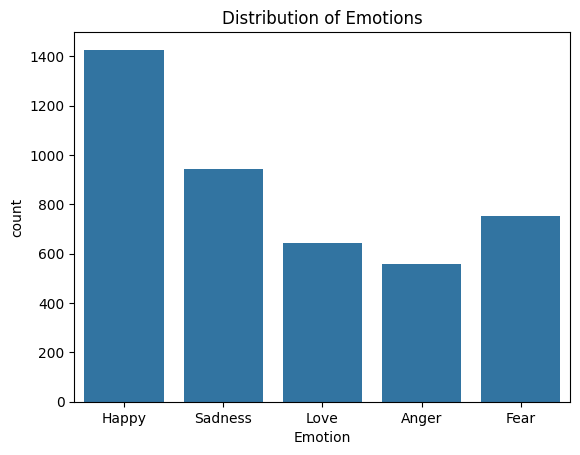

In [10]:
sns.countplot(x='Emotion', data=train_df)
plt.title('Distribution of Emotions')
plt.show()

## EDA Data Test

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1080 non-null   int64  
 1   Category         1080 non-null   object 
 2   Product Name     1080 non-null   object 
 3   Location         1080 non-null   object 
 4   Price            1080 non-null   int64  
 5   Overall Rating   1080 non-null   float64
 6   Number Sold      1080 non-null   int64  
 7   Total Review     1080 non-null   int64  
 8   Customer Rating  1080 non-null   int64  
 9   Customer Review  1080 non-null   object 
dtypes: float64(1), int64(5), object(4)
memory usage: 84.5+ KB


In [12]:
test_df.describe()

,Unnamed: 0,Price,Overall Rating,Number Sold,Total Review,Customer Rating
count,1080.000000,1.080000e+03,1080.000000,1080.000000,1080.000000,1080.000000
mean,2682.698148,2.473201e+05,4.855278,17234.365741,2326.713889,3.054630
std,1580.864945,8.737914e+05,0.107761,78104.490371,3137.336934,1.760912
min,9.000000,1.000000e+02,4.100000,25.000000,7.000000,1.000000
25%,1307.000000,1.950000e+04,4.800000,1582.250000,574.000000,1.000000
50%,2653.000000,6.250000e+04,4.900000,3760.000000,1178.500000,3.000000
75%,4075.500000,1.500000e+05,4.900000,9969.000000,2682.750000,5.000000
max,5397.000000,1.539900e+07,5.000000,1000000.000000,24500.000000,5.000000


In [13]:
test_df.head()

,Unnamed: 0,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review
0,5039,Camera,kain background foto waterproof - Hitam,Kota Bandung,12000,4.8,3205,623,1,"prod dikirim dgn dilipat,tdk digulung padahal ..."
1,1147,Animal Care,Cupang Hias Halfmoon Male / Betta Fish Halfmoo...,Kota Tangerang,99000,4.8,1237,561,5,"Produk top markotop bangeet deh, selalu ada pr..."
2,3623,Beauty,Madame Gie Madame Perfect Brow - Pensil alis -...,Jakarta Barat,20000,4.8,12300,5500,4,Teksturnya keras. Hasilnya tebal. Gampang dipa...
3,4879,Phones and Tablets,ROBOT RT-CH12 CAR MOUNT PHONE HP HOLDER DASHBO...,Jakarta Utara,99000,4.9,5770,3631,5,Build kokoh. Kualitas bahan bagus. Bisa nahan ...
4,4162,Electronics,BESI KAKI KULKAS-RODA KULKAS-TATAKAN KULKAS DA...,Jakarta Timur,72500,4.8,2129,997,5,"Barang sesuai, untuk ukuran mesin cuci 1 tabun..."


In [14]:
test_df.isnull().sum()

,0
Unnamed: 0,0
Category,0
Product Name,0
Location,0
Price,0
Overall Rating,0
Number Sold,0
Total Review,0
Customer Rating,0
Customer Review,0


## Data Preprocessing

### Preprocessing text

In [15]:
# prompt: install sastrawi

!pip install Sastrawi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.5 MB/s eta 0:00:00


In [16]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Create stopword remover
stop_factory = StopWordRemoverFactory()
stopword = stop_factory.create_stop_word_remover()

def preprocess_text(text):
    text = text.lower()
    text = stopword.remove(text)
    text = stemmer.stem(text)
        # Removing mentions
    text = re.sub(r'@\w+', '', text)
    # Removing hashtags
    text = re.sub(r'#\w+', '', text)
    # Removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Removing numbers
    text = re.sub(r'\d+', '', text)
    return text

# Apply preprocessing to the 'Customer Review' column
train_df['Customer Review'] = train_df['Customer Review'].apply(preprocess_text)
test_df['Customer Review'] = test_df['Customer Review'].apply(preprocess_text)


In [17]:
# Display the first few rows of the preprocessed training dataset
train_df.head()

# Display the first few rows of the preprocessed testing dataset
test_df.head()

,Unnamed: 0,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review
0,5039,Camera,kain background foto waterproof - Hitam,Kota Bandung,12000,4.8,3205,623,1,prod kirim dgn lipat tdk gulung padahal utk ba...
1,1147,Animal Care,Cupang Hias Halfmoon Male / Betta Fish Halfmoo...,Kota Tangerang,99000,4.8,1237,561,5,produk top markotop bangeet deh selalu promo i...
2,3623,Beauty,Madame Gie Madame Perfect Brow - Pensil alis -...,Jakarta Barat,20000,4.8,12300,5500,4,tekstur keras hasil tebal gampang pakai gampan...
3,4879,Phones and Tablets,ROBOT RT-CH12 CAR MOUNT PHONE HP HOLDER DASHBO...,Jakarta Utara,99000,4.9,5770,3631,5,build kokoh kualitas bahan bagus nahan beban h...
4,4162,Electronics,BESI KAKI KULKAS-RODA KULKAS-TATAKAN KULKAS DA...,Jakarta Timur,72500,4.8,2129,997,5,barang sesuai ukur mesin cuci tabung pas bang...


### Persiapan Data

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Conv2D, MaxPooling2D, Flatten, GlobalMaxPooling1D, Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assume train_df and test_df are already loaded
# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['Emotion'])

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df['Customer Review'], y, test_size=0.2, random_state=42)


## Modeling

### Model CNN

In [20]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.metrics import accuracy_score

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['Emotion'])

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df['Customer Review'], y, test_size=0.2, random_state=42)

# Tokenize and pad the sequences
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post')
X_val_padded = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(test_df['Customer Review']), maxlen=100, padding='post')

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=50000, output_dim=hp.Choice('embedding_dim', values=[16, 32, 64]), input_length=100))
    model.add(Conv1D(filters=hp.Choice('num_filters', values=[64, 128, 256]), kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]), activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=hp.Choice('dense_units', values=[32, 64, 128]), activation='relu'))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=20,  # Number of different hyperparameter sets to try
                        executions_per_trial=1,
                        directory='my_dir',
                        project_name='emotion_classification')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform the hyperparameter search
tuner.search(X_train_padded, y_train, epochs=20, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
cnn_model = tuner.hypermodel.build(best_hps)
cnn_model.summary()

# Train the model
history_cnn = cnn_model.fit(X_train_padded, y_train, epochs=20, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])

# Evaluate the model on validation set
_, val_accuracy = cnn_model.evaluate(X_val_padded, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on test set (if true labels are available)
if 'Emotion' in test_df.columns:
    test_predictions = cnn_model.predict(X_test_padded)
    test_predictions_classes = test_predictions.argmax(axis=1)
    test_accuracy = accuracy_score(test_df['Emotion'], test_predictions_classes)
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test set (without true labels)
test_predictions = cnn_model.predict(X_test_padded)
test_predictions_classes = test_predictions.argmax(axis=1)

# Prepare the submission file
test_df['Predicted Emotion'] = label_encoder.inverse_transform(test_predictions_classes)
submission_cnn = test_df[['Unnamed: 0', 'Predicted Emotion']]
submission_cnn.columns = ['id', 'Emotion']
# submission_cnn.to_csv('predictions-cnn.csv', index=False, sep=',')

# Display the first few rows of the submission
print(submission_cnn.head())


Trial 20 Complete [00h 00m 47s]
val_accuracy: 0.33796295523643494

Best val_accuracy So Far: 0.6168981194496155
Total elapsed time: 00h 23m 07s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3264 - loss: 1.5565 - val_accuracy: 0.4653 - val_loss: 1.2953
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5160 - loss: 1.1405 - val_accuracy: 0.4861 - val_loss: 1.0412
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5762 - loss: 0.9071 - val_accuracy: 0.5324 - val_loss: 0.9959
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7145 - loss: 0.7430 - val_accuracy: 0.5706 - val_loss: 0.9863
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8004 - loss: 0.5626 - val_accuracy: 0.5845 - val_loss: 1.0607
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8617 - loss: 0.3995 - val_accuracy: 0.5880 - val_loss: 1.1887
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9133 - loss: 0.2891 - val_accuracy: 0.5787 - val_loss: 1.3440
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5540 - loss: 0.9962
Validation Accuracy: 0.5

### Model RNN-LSTM

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.metrics import accuracy_score

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['Emotion'])

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df['Customer Review'], y, test_size=0.2, random_state=42)

# Tokenize and pad the sequences
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post')
X_val_padded = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(test_df['Customer Review']), maxlen=100, padding='post')

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=50000, output_dim=hp.Choice('embedding_dim', values=[16, 32, 64]), input_length=100))
    model.add(LSTM(units=hp.Choice('lstm_units', values=[32, 64, 128]), return_sequences=True))
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])))
    model.add(LSTM(units=hp.Choice('lstm_units', values=[32, 64, 128])))
    model.add(Dense(units=hp.Choice('dense_units', values=[32, 64, 128]), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=20,  # Number of different hyperparameter sets to try
                        executions_per_trial=1,
                        directory='my_dir',
                        project_name='emotion_classification')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform the hyperparameter search
tuner.search(X_train_padded, y_train, epochs=20, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
lstm_model = tuner.hypermodel.build(best_hps)
lstm_model.summary()

# Train the model
history_lstm = lstm_model.fit(X_train_padded, y_train, epochs=20, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])

# Evaluate the model on validation set
_, val_accuracy = lstm_model.evaluate(X_val_padded, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on test set (if true labels are available)
if 'Emotion' in test_df.columns:
    test_predictions = lstm_model.predict(X_test_padded)
    test_predictions_classes = test_predictions.argmax(axis=1)
    test_accuracy = accuracy_score(test_df['Emotion'], test_predictions_classes)
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test set (without true labels)
test_predictions = lstm_model.predict(X_test_padded)
test_predictions_classes = test_predictions.argmax(axis=1)

# Prepare the submission file
test_df['Predicted Emotion'] = label_encoder.inverse_transform(test_predictions_classes)
submission_lstm = test_df[['Unnamed: 0', 'Predicted Emotion']]
submission_lstm.columns = ['id', 'Emotion']
# submission_lstm.to_csv('predictions-lstm.csv', index=False, sep=',')

# Display the first few rows of the submission
print(submission_lstm.head())


Reloading Tuner from my_dir/emotion_classification/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - accuracy: 0.3221 - loss: 1.5756 - val_accuracy: 0.3345 - val_loss: 1.5531
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.3266 - loss: 1.5533 - val_accuracy: 0.3345 - val_loss: 1.5544
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.3301 - loss: 1.5500 - val_accuracy: 0.3345 - val_loss: 1.5502
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.3243 - loss: 1.5479 - val_accuracy: 0.3345 - val_loss: 1.5510
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.3302 - loss: 1.5495 - val_accuracy: 0.3345 - val_loss: 1.5511
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.3281 - loss: 1.5574 - val_accuracy: 0.3345 - val_loss: 1.5515
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3359 - loss: 1.5547
Validation Accuracy: 0.3345
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
     id Emotion
0  5039   Happy
1  1147   Happy
2  3623   Happy
3  4879   Happy

### Model Transformer Encoder

In [23]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.metrics import accuracy_score

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['Emotion'])

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df['Customer Review'], y, test_size=0.2, random_state=42)

# Tokenize and pad the sequences
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post')
X_val_padded = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(test_df['Customer Review']), maxlen=100, padding='post')

# Define the transformer encoder layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Define the model building function for Keras Tuner
def build_model(hp):
    inputs = Input(shape=(100,))
    embedding_layer = Embedding(input_dim=50000, output_dim=hp.Choice('embedding_dim', values=[16, 32, 64]), input_length=100)(inputs)

    x = transformer_encoder(embedding_layer, head_size=hp.Choice('head_size', values=[32, 64, 128]),
                            num_heads=hp.Choice('num_heads', values=[2, 4, 8]),
                            ff_dim=hp.Choice('ff_dim', values=[32, 64, 128]),
                            dropout=hp.Choice('dropout', values=[0.1, 0.2, 0.3]))

    x = GlobalAveragePooling1D()(x)
    x = Dropout(hp.Choice('dropout', values=[0.1, 0.2, 0.3]))(x)
    x = Dense(hp.Choice('dense_units', values=[32, 64, 128]), activation='relu')(x)
    outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=20,
                        executions_per_trial=1,
                        directory='my_dir',
                        project_name='emotion_classification')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform the hyperparameter search
tuner.search(X_train_padded, y_train, epochs=20, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
transformer_model = tuner.hypermodel.build(best_hps)
transformer_model.summary()

# Train the model
history_transformer = transformer_model.fit(X_train_padded, y_train, epochs=20, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])

# Evaluate the model on validation set
_, val_accuracy = transformer_model.evaluate(X_val_padded, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on test set (if true labels are available)
if 'Emotion' in test_df.columns:
    test_predictions = transformer_model.predict(X_test_padded)
    test_predictions_classes = test_predictions.argmax(axis=1)
    test_accuracy = accuracy_score(test_df['Emotion'], test_predictions_classes)
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test set (without true labels)
test_predictions = transformer_model.predict(X_test_padded)
test_predictions_classes = test_predictions.argmax(axis=1)

# Prepare the submission file
test_df['Predicted Emotion'] = label_encoder.inverse_transform(test_predictions_classes)
submission_transformer = test_df[['Unnamed: 0', 'Predicted Emotion']]
submission_transformer.columns = ['id', 'Emotion']
# submission_transformer.to_csv('predictions-transformer.csv', index=False, sep=',')

# Display the first few rows of the submission
print(submission_transformer.head())


Reloading Tuner from my_dir/emotion_classification/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 100, 16)   │    800,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 16)   │      4,304 │ embedding_3[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 100, 16)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 16)   │         32 │ dropout_3[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 16)   │          0 │ layer_normalizat… │
│                     │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 100, 32)   │        544 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 100, 32)   │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 100, 16)   │        528 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 16)   │         32 │ dense_7[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 16)   │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 16)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      2,176 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5)         │        645 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 808,261 (3.08 MB)

 Trainable params: 808,261 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.3177 - loss: 1.5802 - val_accuracy: 0.3345 - val_loss: 1.5564
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.3359 - loss: 1.5473 - val_accuracy: 0.3681 - val_loss: 1.5015
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.4052 - loss: 1.4294 - val_accuracy: 0.5185 - val_loss: 1.0803
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.5639 - loss: 0.9731 - val_accuracy: 0.6076 - val_loss: 0.9212
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7524 - loss: 0.6331 - val_accuracy: 0.6134 - val_loss: 1.0088
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8550 - loss: 0.4224 - val_accuracy: 0.5938 - val_loss: 1.2399
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9110 - loss: 0.2806 - val_accuracy: 0.5938 - val_loss: 1.3765
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5918 - loss: 0.9388
Validation Accuracy: 

## Pemilihan Model Terbaik dan Prediksi

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Membandingkan akurasi validasi dari ketiga model
models = {
    'CNN': {
        'model': cnn_model,
        'history': history_cnn,
        'submission': submission_cnn
    },
    'LSTM': {
        'model': lstm_model,
        'history': history_lstm,
        'submission': submission_lstm
    },
    'Transformer': {
        'model': transformer_model,
        'history': history_transformer,
        'submission': submission_transformer
    }
}


## Pembuatan File Submission

In [25]:
best_model_name = max(models, key=lambda name: models[name]['history'].history['val_accuracy'][-1])
best_model = models[best_model_name]

# Save the best model predictions to submission.csv
best_model['submission'].to_csv('submission-best.csv', index=False, sep=',')

## Grafik training validation, lost, dan akurasi setiap model

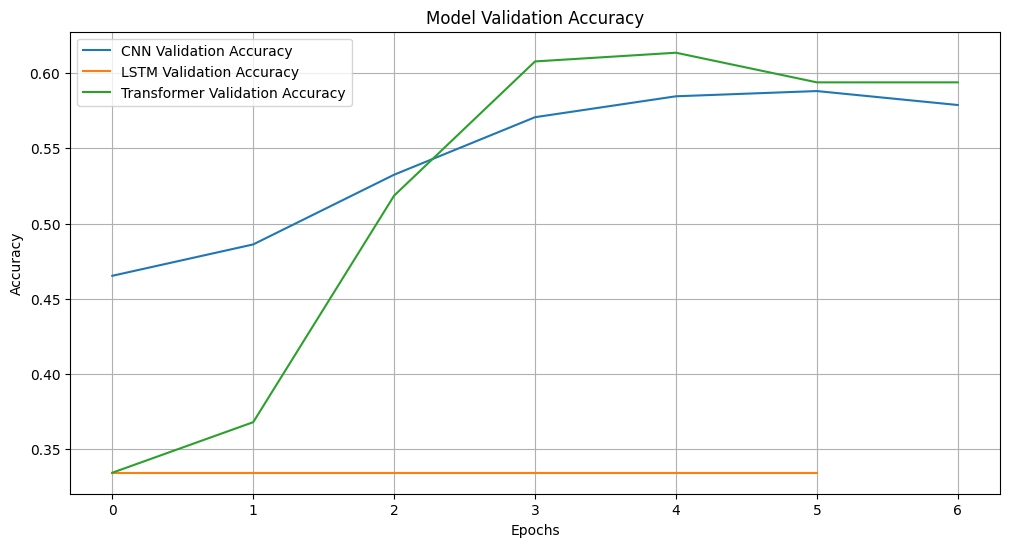

Best model is: Transformer
     id Emotion
0  5039    Fear
1  1147    Love
2  3623   Happy
3  4879   Happy
4  4162   Happy


In [26]:
# Plotting the accuracy of each model
plt.figure(figsize=(12, 6))
for model_name, data in models.items():
    plt.plot(data['history'].history['val_accuracy'], label=f'{model_name} Validation Accuracy')

plt.title('Model Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best model is: {best_model_name}")
print(best_model['submission'].head())